# MKS - Inverses Pendel

<div align="center">
  <a href="https://en.wikipedia.org/wiki/Inverted_pendulum">
    <img src="https://upload.wikimedia.org/wikipedia/commons/0/00/Cart-pendulum.svg" 
    alt="Images" width="250" height="100">
  </a>
</div>

### Importieren benötigter Bibliotheken

In [1]:
from __future__ import print_function, division
from sympy import symbols, simplify, trigsimp
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point, Particle
from sympy.physics.mechanics import inertia, RigidBody, KanesMethod
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)

# 1. Kinematik

### Koordinatensysteme / Bezugssysteme

In [2]:
# Initialisieren der benötigten Koordinatensysteme
inertial_frame = ReferenceFrame('I')
cart_frame = ReferenceFrame('C')   
pendulum_frame = ReferenceFrame('B')

### Orientierung und Zwangsbedingungen an den Koordinatensystemen

In [3]:
# Veränderliche Größen
theta = dynamicsymbols('theta')
x = dynamicsymbols('x')

In [4]:
# Zwangsbedingung der Bezugssysteme zum Inertialsystem
cart_frame.orient_space_fixed(inertial_frame, (0,0,0), '231')

pendulum_frame.orient(inertial_frame, 'Axis', (theta, cart_frame.z))

In [5]:
# Position von Pendulum mit der folgenden Rotationsmatrix berechenbar:
pendulum_frame.dcm(inertial_frame)

Matrix([
[ cos(theta), sin(theta), 0],
[-sin(theta), cos(theta), 0],
[          0,          0, 1]])

### Massepunkte und Gelenkpunkte

In [6]:
# Distanz zw. Ursprungspunkt und Wagenpunkt/Ankerpunkt
# Ursprungspunkt festsetzen
origin = Point('O')
origin.set_vel(inertial_frame, 0) 

# Ankerpunkt für Pendulum und Mittelpunkt des Wagens
ankle = Point('A')
ankle.set_pos(origin, x * inertial_frame.x)

In [7]:
# Endpunkt des Pendulums
pendulum_end = Point('P_1')

# Länge für Pendulum
pendulum_length = symbols('l')

In [8]:
# Position des Endpunktes P_1 vom Pendulum
pendulum_end.set_pos(ankle, pendulum_length * pendulum_frame.y)
pendulum_end.pos_from(ankle).express(inertial_frame).simplify()

- l*sin(theta)*I.x + l*cos(theta)*I.y

In [9]:
# Massenschwerpunkt des Pendulums
pendulum_mass_length = symbols('l_m')
pendulum_mass_center = Point('P_m')
pendulum_mass_center.set_pos(ankle, pendulum_mass_length * pendulum_frame.y)

### Aufstellen der Differentialgleichungen

In [10]:
# Geschwindigkeit des Wagens
cart_vel = dynamicsymbols('v_cart')

In [11]:
# Winkelgeschwindigkeit des Pendulums
omega = dynamicsymbols('omega')

In [12]:
# Voraussetzung für Bewegungsgleichung nach Kanes-Methode
# tranlat. Geschindigkeit:
kinematical_differential_equations = [cart_vel - x.diff()] 

# rotat. Geschwindigkeit:
kinematical_differential_equations.append(omega - theta.diff())

kinematical_differential_equations

[v_cart - x', omega - theta']

In [13]:
# Der Ankerpunkt wird mit Wagengeschwindigkeit angenommen
ankle.set_vel(inertial_frame, cart_vel*inertial_frame.x)

In [14]:
# Die Winkelgeschwindigkeit rotiert um die Z-Achse 
pendulum_frame.set_ang_vel(cart_frame, omega*cart_frame.z)

In [15]:
# Gibt den Winkelgeschwindigkeitsvektor des ReferenceFrame zurück
pendulum_frame.ang_vel_in(inertial_frame)

theta'*I.z

# 2. Massenträgheiten

### Massenträgheiten

In [16]:
pendulum_mass = symbols('m')

In [17]:
pendulum_inertia = symbols('I_p')

In [18]:
# Das Dyadsiche Produkt ermöglicht das Speichern der Trägheit als Tensor in Abhängigkeit zum Bezugssystem
pendulum_inertia_dyadic = inertia(pendulum_frame, 0, 0, pendulum_inertia)
pendulum_inertia_dyadic

I_p*(B.z|B.z)

In [19]:
pendulum_inertia_dyadic.to_matrix(pendulum_frame)

Matrix([
[0, 0,   0],
[0, 0,   0],
[0, 0, I_p]])

In [20]:
pendulum_central_inertia = (pendulum_inertia_dyadic, pendulum_mass_center)

In [21]:
# Wagenmittelpunkt entspricht gleich Masseschwerpunkt des Wagens
cart_mass = symbols('M')

# Particle statt Rigidbody, da keine Trägheitsmomente für den Wagen selbst
cart = Particle('Cart', ankle, cart_mass)

In [22]:
# Komplette Beschreibung des Rigid Bodys besteht aus: Massenschwerpunkt, Bezugssystem, Masse und Trägheit
pendulum = RigidBody('Pendulum', pendulum_mass_center, pendulum_frame,
                      pendulum_mass, pendulum_central_inertia)

# 3. Kinetik (extern aufgeprägte Kräfte)

In [23]:
g = symbols('g')

In [24]:
pendulum_grav_force_vector = -pendulum_mass * g * inertial_frame.y
pendulum_grav_force_vector

- g*m*I.y

In [25]:
pendulum_grav_force = (pendulum_mass_center, pendulum_grav_force_vector)

In [26]:
cart_grav_force_vector = -cart_mass * g * inertial_frame.y
cart_grav_force_vector

- M*g*I.y

In [27]:
cart_grav_force = (ankle, cart_grav_force_vector)

In [28]:
# Zusätzlich kann an Rotations-FHG der Gelenke auch ein Moment aufgeprägt werden
ankle_torque, p1_torque = dynamicsymbols('T_a, T_p1')
pendulum_torque_vector = ankle_torque * cart_frame.z - p1_torque * cart_frame.z
pendulum_torque = (pendulum_frame, pendulum_torque_vector)
pendulum_torque_vector

(T_a - T_p1)*C.z

# 4. Aufstellen der Bewegungsgleichungen

In [29]:
# Generelle Koordinaten
positions = [x, theta]

# Generelle Geschwindigkeiten
speeds = [cart_vel, omega]

In [30]:
# bereits im Kapitel 1 - Kinematik definiert
kinematical_differential_equations

[v_cart - x', omega - theta']

In [31]:
# Zusammentragen aller von außen aufgeprägten Kräfte
loads = [cart_grav_force,
         pendulum_grav_force,
         pendulum_torque]
loads

[(A, - M*g*I.y), (P_m, - g*m*I.y), (B, (T_a(t) - T_p1(t))*C.z)]

In [32]:
# Zusammenfassen der angelegten Starrkörper
bodies = [cart, 
          pendulum]
bodies

[Cart, Pendulum]

<p>Die Formulierung der Bewegungsgleichungen nach Kane sieht der bekannten Form nach Newton Euler sehr ähnlich:</p>
<p>Kanes Formulierung: $F_r + F_r^* = 0$</p>
<p>Newton Euler Formulierung: ${F} = {m}{a} \hspace{1cm} {T} = {I}{\alpha}$</p>

In [33]:
#kane = KanesMethod(inertial_frame, angles, speeds, kinematical_differential_equations)
kane = KanesMethod(inertial_frame, positions, speeds, kinematical_differential_equations)

In [34]:
fr, frstar = kane.kanes_equations(bodies, loads)

In [35]:
fr

Matrix([
[                              0],
[g*l_m*m*sin(theta) + T_a - T_p1]])

In [36]:
frstar

Matrix([
[-l_m*m*omega**2*sin(theta) + l_m*m*cos(theta)*omega' - (M + m)*v_cart'],
[                    l_m*m*cos(theta)*v_cart' - (I_p + l_m**2*m)*omega']])

In [37]:
trigsimp(fr + frstar)

Matrix([
[              -l_m*m*omega**2*sin(theta) + l_m*m*cos(theta)*omega' - (M + m)*v_cart'],
[g*l_m*m*sin(theta) + l_m*m*cos(theta)*v_cart' - (I_p + l_m**2*m)*omega' + T_a - T_p1]])

In [38]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1, 0,                 0,                 0],
[0, 1,                 0,                 0],
[0, 0,             M + m, -l_m*m*cos(theta)],
[0, 0, -l_m*m*cos(theta),    I_p + l_m**2*m]])

In [39]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                         v_cart],
[                          omega],
[     -l_m*m*omega**2*sin(theta)],
[g*l_m*m*sin(theta) + T_a - T_p1]])

# 5. Lösen der Bewegungsgleichung

In [40]:
from numpy import deg2rad, rad2deg, array, zeros, linspace
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
from sympy.physics.vector import init_vprinting, vlatex
%matplotlib inline
rcParams['figure.figsize'] = (14.0, 6.0)

C:\Users\lenna\anaconda3\lib\site-packages\sympy\printing\ccode.py:8: SymPyDeprecationWarning: 

importing from sympy.printing.ccode has been deprecated since SymPy
1.7. Use Import from sympy.printing.c instead. See
https://github.com/sympy/sympy/issues/20256 for more info.

  SymPyDeprecationWarning(


In [41]:
constants = [cart_mass,
             pendulum_length,
             pendulum_mass_length,
             pendulum_mass,
             pendulum_inertia,
             g]
constants

[M, l, l_m, m, I_p, g]

In [42]:
specified = [ankle_torque, p1_torque]

In [43]:
# Gleichung nach x' umstellen
right_hand_side = generate_ode_function(forcing_vector, 
                                        positions, 
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [44]:
# Festlegen der Initialbedingungen für die numerische Lösung der DGL

# Zu Beginn werden beide Geschwindigkeiten auf 0 gesetzt
# 0: x-Position, 1: theta, 2: cart_vel, 3: omega
x0 = zeros(4)
x0[0] = 1
x0[1] = deg2rad(20)

In [45]:
# Werte für Konstanten 
numerical_constants = array([2.00,  # cart_mass [kg]
                             0.80,  # pendulum_length [m]
                             0.40,  # pendulum_com_length [m]
                             4.00,  # pendulum_mass [kg]
                             0.64,  # pendulum_inertia [kg*m^2]
                             9.81], # acceleration due to gravity [m/s^2]
                            )

In [46]:
# Gelenkmomente initial auf 0
numerical_specified = array([0, 0])

<p>Mit den bekannten Anfangsbedingungen wollen wir über unseren gewünschten Beobachtungszeitraum numerisch integrieren.</p>
<p>Dazu geben wir dem Solver (z. B. Runge-Kutta) unsere Anfangsbedingungen, die Gleichung für x' und den Zeitraum sowie die Schrittweite t.</p>

In [47]:
# Numerische Integration mit gegebenen Anfangsbedingungen, Gleichung für x'
# und den Zeitraum sowie die Schrittweite t
frames_per_sec = 30
final_time = 18
t = linspace(0, final_time, final_time * frames_per_sec)

In [48]:
# Lösung des Anfangswertproblems für steife oder nicht-steife Systeme erster Ordnung 
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

# 6. Visualisierung

Text(0, 0.5, 'Zurückgelegter Weg [m]')

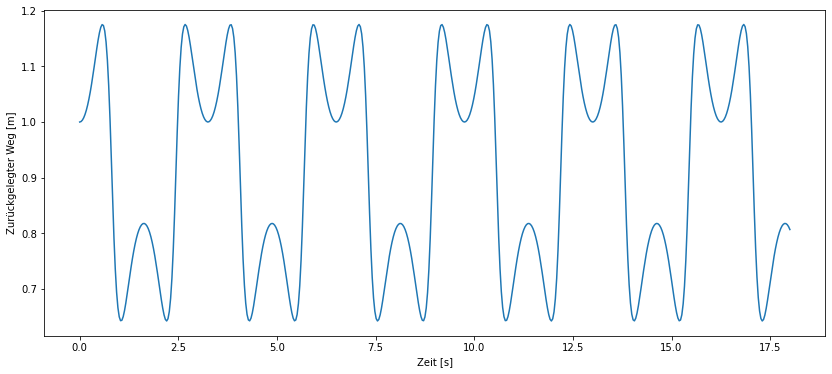

In [49]:
#Distanz x zwischen Ursprungspunkt und Wagen über die Simulationsdauer
plot(t, y[:,0])  
xlabel('Zeit [s]')
ylabel('Zurückgelegter Weg [m]')

Text(0, 0.5, 'Winkel [deg]')

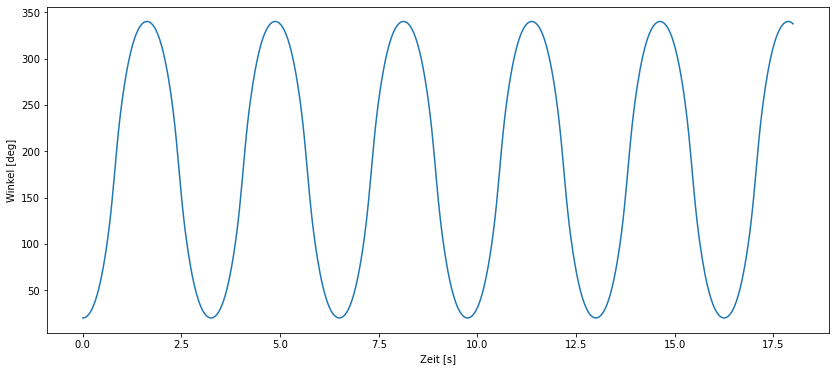

In [50]:
# Darstellung des Winkels über die Simulationsdauer
plot(t, rad2deg(y[:, 1:2]))
xlabel('Zeit [s]')
ylabel('Winkel [deg]')

Text(0, 0.5, 'Wagengeschwindigkeit')

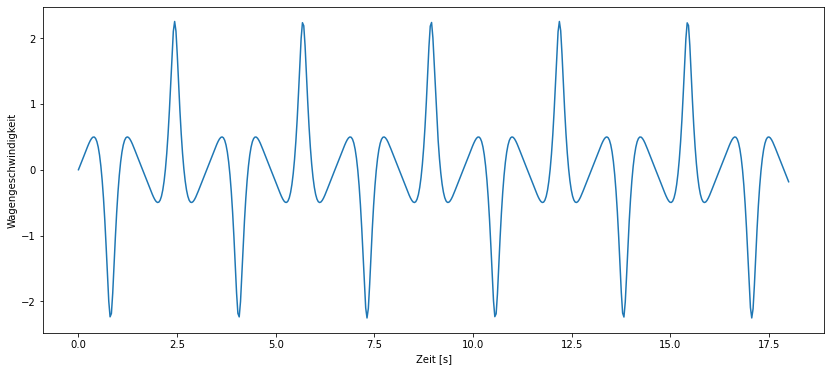

In [51]:
# Wagengeschwindigkeit über die Simulationsdauer
plot(t, y[:,2]) 
xlabel('Zeit [s]')
ylabel('Wagengeschwindigkeit')

Text(0, 0.5, 'Winkelgeschw. [deg/s]')

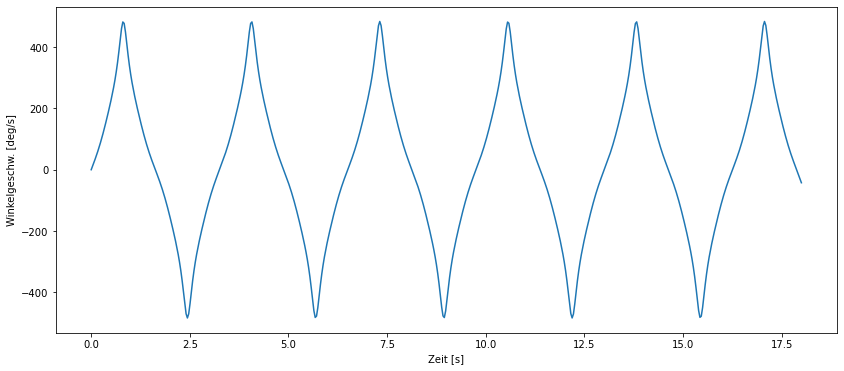

In [52]:
# Darstellung der Winkelgeschwindigkeit über die Simulationsdauer
plot(t, rad2deg(y[:, 3:]))
xlabel('Zeit [s]')
ylabel('Winkelgeschw. [deg/s]')

In [53]:
from pydy.viz.shapes import Cylinder, Sphere, Cube
import pydy.viz
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz.scene import Scene

# Wichtige Punkte darstellen
ankle_shape = Sphere(color='black', radius=0.1)
p1_shape = Sphere(color='black', radius=0.1)
origin_shape = Sphere(color='yellow', radius=0.1) 


# Setzen der erzeugten Geometrien an die Punkte
origin_vis_frame = VisualizationFrame(inertial_frame, origin, origin_shape)
ankle_viz_frame = VisualizationFrame(inertial_frame, ankle, ankle_shape)
p1_viz_frame = VisualizationFrame(inertial_frame, pendulum_end, p1_shape)

# Umformen der Konstanten in für das Programm leserliches Format
constants_dict = dict(zip(constants, numerical_constants))


# Setzen der Geometrie für die Starrkörper
cart_shape = Cube(length=0.3, color='green')
cart_vis_frame = VisualizationFrame('Cart', cart_frame, ankle, cart_shape)

pendulum_center = Point('p1_c')
pendulum_center.set_pos(ankle, pendulum_length / 2 * pendulum_frame.y)

pendulum_shape = Cylinder(radius=0.08, length=constants_dict[pendulum_length], color='blue')
pendulum_viz_frame = VisualizationFrame('Pendulum', pendulum_frame, pendulum_center, pendulum_shape)


# Erstellen der Szene mit dem Inertialsystem/Ankerpunkt in der Mitte
#global scene
scene = Scene(inertial_frame, origin)

# Laden der Starrkörper in die Szene
scene.visualization_frames = [ankle_viz_frame,
                              p1_viz_frame,
                              cart_vis_frame,
                              pendulum_viz_frame,
                              origin_vis_frame
                             ]

# Darstellung und einfügen der Ergebnisse
scene.states_symbols = positions + speeds
scene.constants = constants_dict
scene.states_trajectories = y

# öffnen der Simulation
#scene.display()

In [54]:
import ipywidgets as widgets
from IPython.display import display

button = widgets.Button(description="Run MKS")
display(button)

def on_button_clicked(b):
    
    #global scene
    
    scene.display()

button.on_click(on_button_clicked)

Button(description='Run MKS', style=ButtonStyle())